# Classification - Part 2: Multiclass, Multilabel and Multioutput Classification

# 0. MNIST Dataset

1. Importing modules and MNIST dataset
2. Setting `plot_digit` function

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

The MNIST dataset from `fetch_openml()` is already split into training set (first 60,000 images) and test set (last 10,000 images):

In [2]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 0.1. Working with digit `5`

We'd be working with digit `5` at `X[0]` instead of a random digit in this part

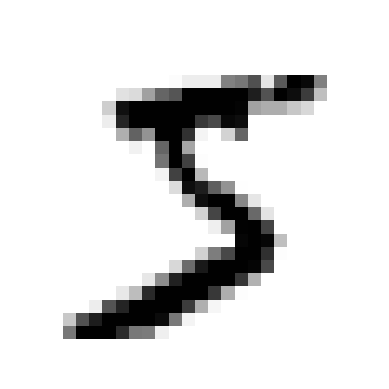

In [3]:
digit=X[0]
plot_digit(digit)

## 0.2. Random Number Generator

In [4]:
import random

Generate a random number to use as random state for the classifiers

In [5]:
rng_state=random.randint(0, 2**32 - 1)
rng_state

1412660185

# 2. Multiclass Classification

Ref: https://scikit-learn.org/stable/modules/multiclass.html

#### Native multi-class classifiers
- Logistic Regression
- Random Forest
- Gaussian Naive Bayes (GaussianNB)

#### Binary classifiers can also be used with multiclass algorithms
- Support Vector Machine (SVM) Classifier (SVC)
- Stochastic Gradient Descent (SGD)

#### Multiclass algorithms
- One-Vs-One (OvO): $N\times\frac{N-1}{2}$ classifers for $N$ classes
- One-Vs-The-Rest (OvR) (a.k.a. One-Vs-All, OvA): $N$ classifiers for $N$ classes

## 2.1. Support Vector Machine (SVM) Classifier (SVC)

In [6]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=rng_state)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=1412660185)

In [7]:
svm_clf.predict([digit])

array(['5'], dtype=object)

In [8]:
svm_clf.decision_function([digit]).round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [9]:
svm_clf.decision_function([digit]).argmax()

5

In [10]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [11]:
svm_clf.classes_[svm_clf.decision_function([digit]).argmax()]

'5'

OvO algorithm uses $N\times\frac{N-1}{2}$ classifers for $N$ classes, check the number of classifiers:

In [12]:
len(svm_clf.n_iter_)

45

## 2.2. SVC using OvR Classifier

Ref: https://scikit-learn.org/stable/modules/multiclass.html

`SVC` is `Multiclass as One-Vs-One`, it is possible to use `One-Vs-The-Rest` with the `OneVsRestClassifier` class

In [13]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=rng_state))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=1412660185))

In [14]:
ovr_clf.predict([digit])

array(['5'], dtype='<U1')

OvR algorithm uses $N$ classifiers for $N$ classes, check the number of classifiers:

In [15]:
len(ovr_clf.estimators_)

10

In [16]:
ovr_clf.decision_function([digit]).round(2)

array([[-1.33, -1.79, -1.39, -0.94, -2.29,  0.81, -1.72, -1.21, -1.64,
        -1.79]])

## 2.3. SGD using OvR Classifier

Scikit-Learn uses the OvR strategy under the hood for SGD

In [17]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=rng_state)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=1412660185)

In [18]:
sgd_clf.predict([digit])

array(['3'], dtype='<U1')

The classifier isn't very confident about the prediction: almost all scores are very negative

In [19]:
sgd_clf.decision_function([digit]).round(2)

array([[-21437.57, -42048.79, -13148.62,   -833.45, -23354.09,   -943.37,
        -24342.87, -16387.65, -12917.08, -14800.57]])

A simple cross-validation score check using `accuracy` shows >85% in score:

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.86715, 0.8891 , 0.8686 ])

## 2.4. Error Analysis

`ConfusionMatrixDisplay` renders a heatmap instead of the text array format of `ConfusionMatrix`, which helps in visualizing the model performance

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

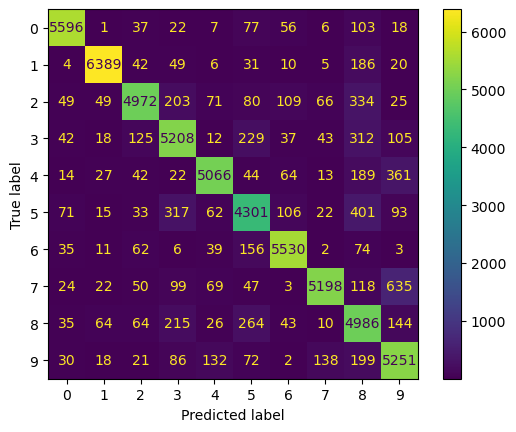

In [22]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

### 2.4.1. CM Normalized by Row

Normalizing the CM by row helps to understand of what percentage of the true label is incorrectly predicted as each label

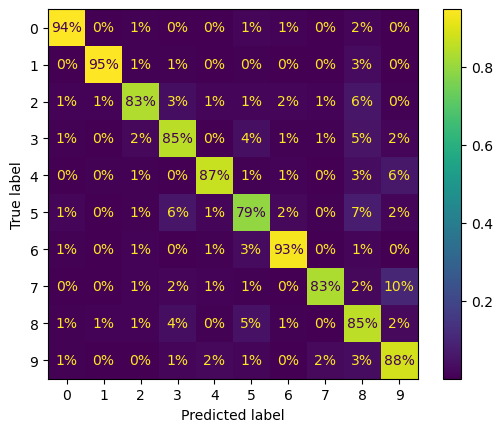

In [23]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')

### 2.4.2. Errors Normalized by Row

Putting zero weight on the correct predictions would make errors stand out more in the visualization, which helps to identify the error rate of incorrect predictions

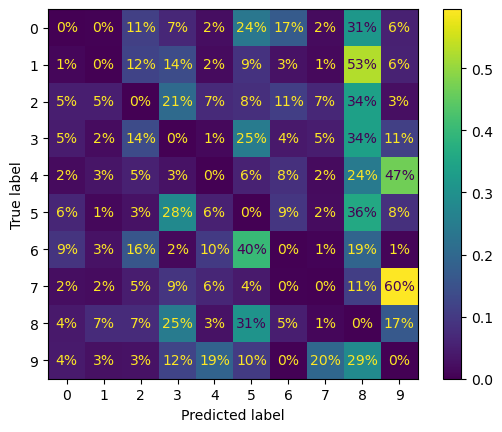

In [24]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format='.0%')

### 2.4.3. Errors Normalized by Column

It is also possible to normalize the confusion matrix by column rather than by row by setting `normalize='pred'`

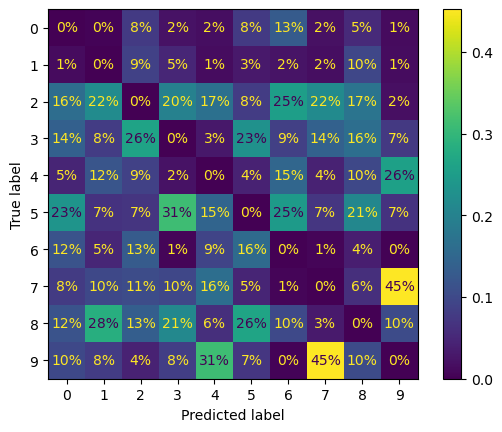

In [25]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='pred', values_format='.0%')

## 3. Multilabel Classification

Ref: https://scikit-learn.org/stable/modules/multiclass.html

`KNeighborsClassifier` supports multilabel classification

Let's construct the classifier for 2 labels:
1. Large: digits $\ge$ 7
2. Odd: odd digits

In [26]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

The classifier correctly predict digit `5` as: not large (`False`) and odd (`True`)

In [27]:
knn_clf.predict([digit])

array([[False,  True]])

## 3.1. Evaluating a multilabel classifier:
- `macro`: Calculate metrics for each label, and find their **unweighted mean**. This does not take label imbalance into account.
- `weighted`: Calculate metrics for each label, and find their average **weighted by support** (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [28]:
from sklearn.metrics import f1_score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9764102655606048

Since the MNIST dataset has pretty well balanced classes, the $F_1$ score between `macro` and `weighted` are quite close

In [29]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

## 3.2. Chain Classifier

To use a classifier that does not natively support multilabel classification, such as `SVC`, one possible strategy is to train one model per label.

However, this strategy may have a hard time capturing the dependencies between the labels.

For example: a large digit (7, 8, or 9) is twice more likely to be odd than even, but the classifier for the "odd" label does not know what the classifier for the "large" label predicted.

To solve this issue, the models can be organized in a chain: when a model makes a prediction, it uses the input features plus all the predictions of the models that come before it in the chain.

In [30]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=rng_state)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=1412660185)

When `cv` hyperparameter is set with `ClassifierChain`, it uses cross-validation to get "clean" (out-of-sample) predictions from each trained model for every instance in the training set, and these predictions will then be used to train all the models later in the chain.

The classifier correctly predict digit `5` as: not large (`0.` i.e. `False`) and odd (`1.` i.e. `True`)

In [31]:
chain_clf.predict([digit])

array([[0., 1.]])